## Importing the libraries

In [35]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

## loading the data

In [10]:
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## data cleaning and preprocessing 

In [11]:
df = df.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time','Summary'])
df.head()

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [12]:
df.isna().sum()

Text    0
dtype: int64

In [16]:
df['Text'] = df['Text'].astype(str)

In [19]:
def cleanse(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text into words
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    #lemmatizing words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a single string
    preprocessed_text = ' '.join(words)
    return preprocessed_text

In [20]:
df['Text'] = df['Text'].apply(cleanse)

In [22]:
df.head()

,Text
0,bought several vitality canned dog food produc...
1,product arrived labeled jumbo salted peanutsth...
2,confection around century light pillowy citrus...
3,looking secret ingredient robitussin believe f...
4,great taffy great price wide assortment yummy ...


## Exploratory Data Analysis

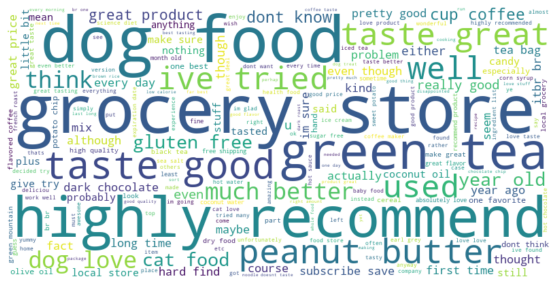

In [24]:
## wordcloud

# Combining all text into a single string
text_combined = ' '.join(df['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

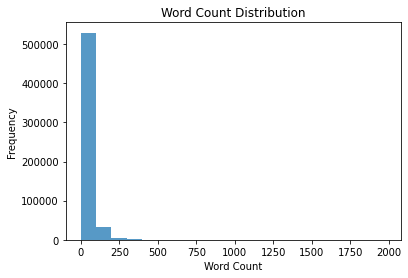

In [26]:
## getting word count
# Word Count Distribution
df['word_count'] = df['Text'].apply(lambda x: len(word_tokenize(x)))
plt.hist(df['word_count'], bins=20, alpha=0.75)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()

In [29]:
## Top N Words
word_tokens = word_tokenize(' '.join(df['Text']))
freq_dist = FreqDist(word_tokens)
top_n_words = freq_dist.most_common(20)
print("Top 20 Words:")
for word, freq in top_n_words:
    print(f"{word}: {freq}")

Top 20 Words:
br: 264617
like: 263536
taste: 211889
good: 197052
one: 189271
flavor: 180520
product: 176806
coffee: 170096
great: 163577
love: 163077
tea: 148838
food: 147842
would: 123364
get: 118935
make: 107129
dog: 105873
really: 100410
time: 97345
dont: 95556
much: 91905


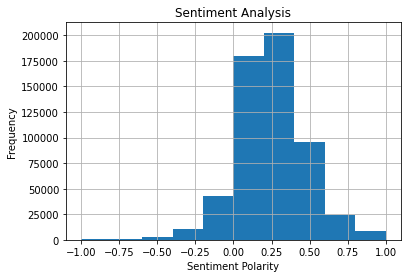

In [30]:
# Sentiment Analysis using textblob
from textblob import TextBlob
df['Sentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment'].hist()
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis')
plt.show()

## creating a document term matrix

In [32]:
cv = CountVectorizer(max_df=0.95,min_df=2,stop_words='english')
# max_df -> words that appear more than 95% of the time will be ignored
# min_df -> words must appear in less than 2 documents to be included in the DTM

In [33]:
dtm = cv.fit_transform(df['Text'])

In [34]:
dtm

<568454x104779 sparse matrix of type '<class 'numpy.int64'>'
	with 16866843 stored elements in Compressed Sparse Row format>

## LDA

In [36]:
LDA = LatentDirichletAllocation(n_components=10,random_state=42)

In [37]:
LDA.fit(dtm)

LatentDirichletAllocation(random_state=42)

In [38]:
# stored words
len(cv.get_feature_names())

104779

In [39]:
len(LDA.components_)

10

In [40]:
LDA.components_
# LDA.components_ is a matrix where each row corresponds to a topic,
# and each column corresponds to a unique word in your vocabulary.

array([[ 0.10000113,  1.46953278,  0.10003884, ...,  0.1       ,
         0.1       ,  0.1       ],
       [ 0.10000266,  4.73033116,  0.10002502, ...,  2.09993072,
         0.10034047,  0.1       ],
       [ 0.1000033 ,  0.10000521,  0.1       , ...,  0.1       ,
         5.099585  ,  0.1       ],
       ...,
       [22.16936013,  0.10001009,  0.10003838, ...,  0.1       ,
         0.1       ,  0.10000399],
       [ 0.10000522,  0.10005785,  0.1       , ...,  0.10005197,
         0.1       ,  8.09998834],
       [ 0.58234219,  0.10002171,  3.09964569, ...,  0.10000194,
         0.1       ,  0.1       ]])

In [42]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index+1}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1
['tried', 'dark', 'blend', 'love', 'roast', 'great', 'strong', 'chocolate', 'br', 'good', 'taste', 'flavor', 'like', 'cup', 'coffee']


THE TOP 15 WORDS FOR TOPIC #2
['ive', 'br', 'really', 'cup', 'make', 'bag', 'love', 'great', 'good', 'green', 'drink', 'like', 'flavor', 'taste', 'tea']


THE TOP 15 WORDS FOR TOPIC #3
['great', 'good', 'year', 'chicken', 'old', 'baby', 'product', 'br', 'like', 'eat', 'love', 'treat', 'cat', 'dog', 'food']


THE TOP 15 WORDS FOR TOPIC #4
['really', 'food', 'coconut', 'dont', 'good', 'soda', 'bottle', 'cat', 'juice', 'flavor', 'drink', 'like', 'taste', 'br', 'water']


THE TOP 15 WORDS FOR TOPIC #5
['didnt', 'got', 'hair', 'smell', 'im', 'day', 'good', 'really', 'chew', 'product', 'dog', 'dont', 'time', 'like', 'br']


THE TOP 15 WORDS FOR TOPIC #6
['try', 'little', 'bag', 'sauce', 'salt', 'sweet', 'really', 'snack', 'great', 'chip', 'love', 'good', 'taste', 'like', 'flavor']


THE TOP 15 WORDS FOR TOPIC #7
['water', 'taste

In [49]:
# This line retrieves the feature names (words or terms) from the vectorizer vect
vocab = cv.get_feature_names()

for i, comp in enumerate(LDA.components_):
    # This line combines the vocabulary (feature names) with the corresponding component values for the current topic.
    vocab_comp = zip(vocab, comp) # It pairs each term with its importance score in the topic.
    # Sorts the term-component pairs based on their importance scores in descending order and selects the top 10 terms.
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    # The script then prints the topic number (index) along with the top 10 terms for that topic.
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
coffee cup like flavor taste good br chocolate strong great 

Topic 1: 
tea taste flavor like drink green good great love bag 

Topic 2: 
food dog cat treat love eat like br product baby 

Topic 3: 
water br taste like drink flavor juice cat bottle soda 

Topic 4: 
br like time dont dog product chew really good day 

Topic 5: 
flavor like taste good love chip great snack really sweet 

Topic 6: 
br use oil product sugar used make using add coconut 

Topic 7: 
taste like bar br good chocolate great make product butter 

Topic 8: 
br syrup bean product plant blue licorice help blood magnesium 

Topic 9: 
product amazon price store box order great bag buy time 



In [50]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):    
    # Empty string to store important words for a topic
    imp_words_topic=""
    # Extracts the topic's components from the LDA model
    comp=LDA.components_[index]
    # This line combines the vocabulary (list of words) with the corresponding component values for the specified topic
    vocab_comp = zip(vocab, comp)
    # Sorts in desc and selects top 50 words
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    # The following for loop iterates through the sorted words and appends them to the imp_words_topic string, separated by spaces
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]
    #This line creates a WordCloud object with a specified width and height
    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [60]:
len(LDA.components_)

10

Wordcloud for topic 1 is:


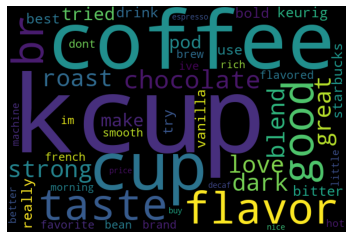

Wordcloud for topic 2 is:


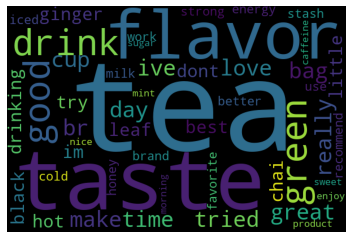

Wordcloud for topic 3 is:


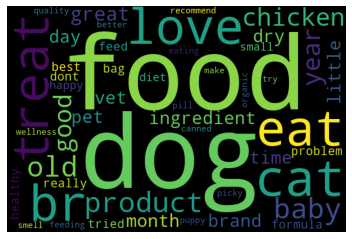

Wordcloud for topic 4 is:


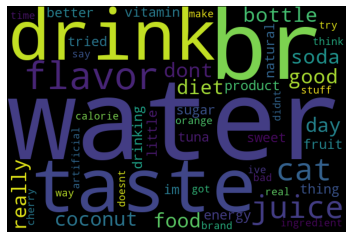

Wordcloud for topic 5 is:


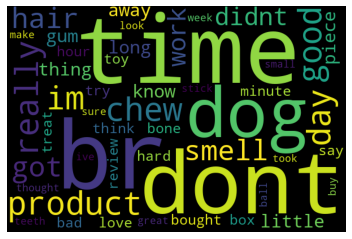

Wordcloud for topic 6 is:


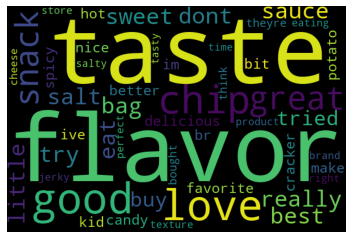

Wordcloud for topic 7 is:


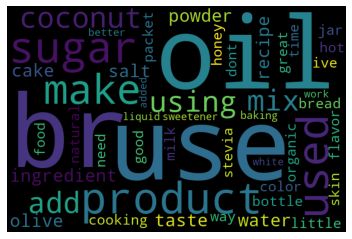

Wordcloud for topic 8 is:


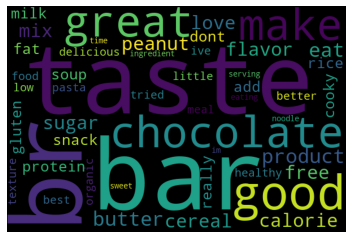

Wordcloud for topic 9 is:


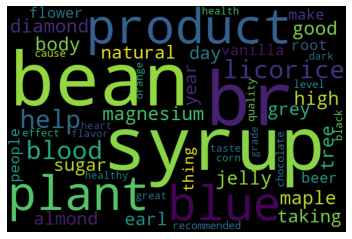

Wordcloud for topic 10 is:


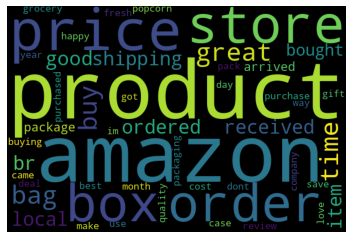

In [59]:
num_topics = len(LDA.components_)
for topic_index in range(num_topics):
    print(f"Wordcloud for topic {topic_index+1} is:")
    draw_word_cloud(topic_index)

## NMF

In [62]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=10,random_state=42)

In [63]:
nmf_model.fit(dtm)

NMF(n_components=10, random_state=42)

In [65]:
len(cv.get_feature_names())

104779

In [66]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index+1}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #1
['chip', 'box', 'little', 'price', 'really', 'amazon', 'time', 'bar', 'taste', 'bag', 'make', 'chocolate', 'love', 'great', 'good']


THE TOP 15 WORDS FOR TOPIC #2
['kcups', 'bold', 'make', 'brew', 'drink', 'keurig', 'bean', 'starbucks', 'blend', 'strong', 'good', 'roast', 'pod', 'cup', 'coffee']


THE TOP 15 WORDS FOR TOPIC #3
['iced', 'drinking', 'taste', 'organic', 'make', 'stash', 'box', 'good', 'drink', 'leaf', 'black', 'cup', 'bag', 'green', 'tea']


THE TOP 15 WORDS FOR TOPIC #4
['review', 'natural', 'make', 'oil', 'use', 'im', 'dont', 'serving', 'vitamin', 'thing', 'organic', 'fat', 'ingredient', 'sugar', 'br']


THE TOP 15 WORDS FOR TOPIC #5
['brand', 'wellness', 'feeding', 'canned', 'feed', 'year', 'ingredient', 'eating', 'dry', 'day', 'diet', 'chicken', 'eat', 'cat', 'food']


THE TOP 15 WORDS FOR TOPIC #6
['vet', 'eat', 'like', 'bone', 'size', 'toy', 'pet', 'time', 'small', 'chew', 'bag', 'love', 'food', 'treat', 'dog']


THE TOP 15 WORDS FOR T

In [67]:
# This line retrieves the feature names (words or terms) from the vectorizer vect
vocab = cv.get_feature_names()

for i, comp in enumerate(nmf_model.components_):
    # This line combines the vocabulary (feature names) with the corresponding component values for the current topic.
    vocab_comp = zip(vocab, comp) # It pairs each term with its importance score in the topic.
    # Sorts the term-component pairs based on their importance scores in descending order and selects the top 10 terms.
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    # The script then prints the topic number (index) along with the top 10 terms for that topic.
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
good great love chocolate make bag taste bar time amazon 

Topic 1: 
coffee cup pod roast good strong blend starbucks bean keurig 

Topic 2: 
tea green bag cup black leaf drink good box stash 

Topic 3: 
br sugar ingredient fat organic thing vitamin serving dont im 

Topic 4: 
food cat eat chicken diet day dry eating ingredient year 

Topic 5: 
dog treat food love bag chew small time pet toy 

Topic 6: 
product use amazon great oil price hair used time order 

Topic 7: 
like taste dont really im sugar try drink smell sweet 

Topic 8: 
water drink taste bottle make drinking coconut bottled ph use 

Topic 9: 
flavor chip favorite tried sweet love vanilla try nice natural 



In [69]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):    
    # Empty string to store important words for a topic
    imp_words_topic=""
    # Extracts the topic's components from the LDA model
    comp=nmf_model.components_[index]
    # This line combines the vocabulary (list of words) with the corresponding component values for the specified topic
    vocab_comp = zip(vocab, comp)
    # Sorts in desc and selects top 50 words
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    # The following for loop iterates through the sorted words and appends them to the imp_words_topic string, separated by spaces
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]
    #This line creates a WordCloud object with a specified width and height
    wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Wordcloud for topic 1 is:


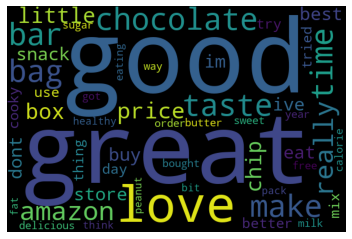

Wordcloud for topic 2 is:


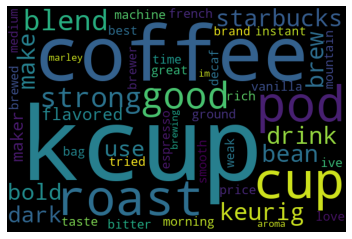

Wordcloud for topic 3 is:


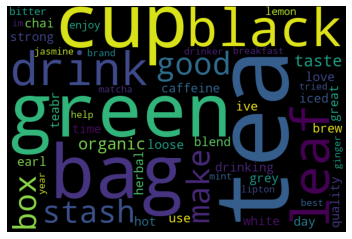

Wordcloud for topic 4 is:


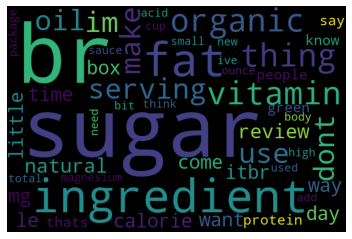

Wordcloud for topic 5 is:


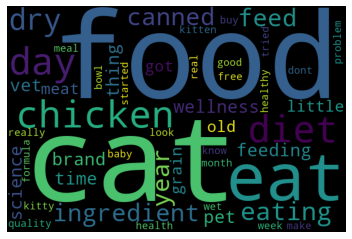

Wordcloud for topic 6 is:


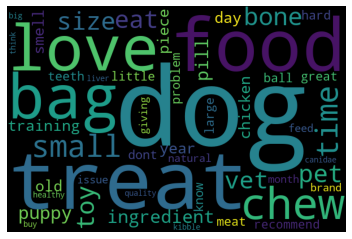

Wordcloud for topic 7 is:


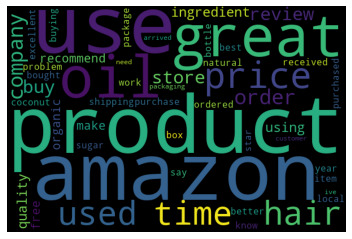

Wordcloud for topic 8 is:


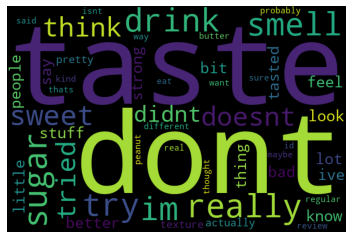

Wordcloud for topic 9 is:


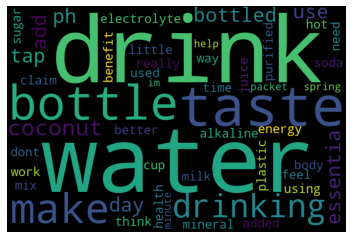

Wordcloud for topic 10 is:


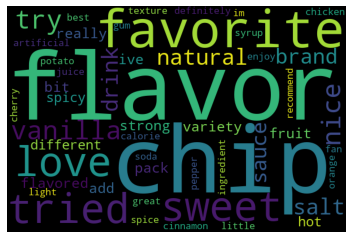

In [70]:
num_topics = len(nmf_model.components_)
for topic_index in range(num_topics):
    print(f"Wordcloud for topic {topic_index+1} is:")
    draw_word_cloud(topic_index)